<a href="https://colab.research.google.com/github/RobSpiewakowski/Public_repository/blob/main/Kaggle_ML_project_real_estate_prices_in_Melbourne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project description:

We will use ML models to predict real estate prices in Melbourne, Australia.
To predict, we will use both scikit-learn and TensorFlow modules, and check, which one is better.

# Setup an environment, import modules and download data

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
# Installing kaggle and downloading data:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dansbecker/melbourne-housing-snapshot

Saving kaggle.json to kaggle.json
  0% 0.00/451k [00:00<?, ?B/s]
100% 451k/451k [00:00<00:00, 61.8MB/s]


In [21]:
# Extract z zip file:
file_name = 'melbourne-housing-snapshot.zip'

with ZipFile(file_name, 'r') as zip:
  zip.printdir()

  zip.extractall()

# Create a DataFrame with data:
data = pd.read_csv('/content/melb_data.csv', delimiter = ',')

# Looking for lack of data:
data.info()

File Name                                             Modified             Size
melb_data.csv                                  2019-09-21 04:36:08      2091239
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 no

# First analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f765c858dd0>,
      dtype=object)

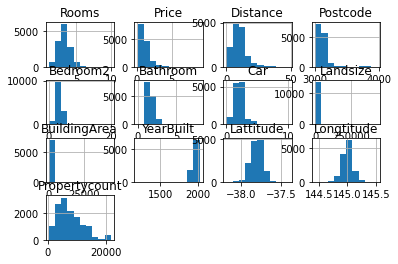

In [22]:
# Distribution od all numerical variables:
num_variables = ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude',
       'Longtitude', 'Propertycount']

data.hist(bins = 10)

In [23]:
# Real estates' price related to real estates' area with info about Suburb:
plot1 = px.scatter(data, x = 'Landsize', y = 'Price', color = 'Suburb', title = 'Price of real estate related to it\'s Landsize')
plot1.show()

# Data pre-processing

Our dataset includes the following data:

'Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount'.

As we can realize, not all are important. It's time to drop unimportant ones:

* Suburb - is not key-value -> drop!
* Address - contains almost the same information like Suburb -> drop!
* Rooms - one of the most important variable -> stays,
* Type - Says, if estate is apartament, cottage home or villa -> stays,
* Price - it's the variable to be predicted by model -> of course, stays,
* Method - Not important for us -> drop!
* SellerG - The name of real estate agent is not important for model -> drop!
* Date -> drop!,
* Distance - Distance from central business district. Also important -> stays,
* Postcode - almost the same like Suburb -> drop!
* Bedroom2 - contains the same information like rooms -> drop!
* Bathroom - also very important -> stays,
* Car - Number of carspots - important -> stays,
* Landsize - one of the most important variable -> stays,
* BuildingArea - there is a huge lack of data here -> srop!
* YearBuilt - not important -> drop!
* CouncilArea - contains the same information like Suburb -> drop!
* Lattitude - contains almost the same information like Landsize -> drop!
* Longitude - like above -> drop!
* Regionname - contains the same info like Suburb -> drop!
* PropertyCount - Number of properties, that exist in suburb is not important -> drop!

In [24]:
# Delete unimportant variables:
var_2_drop = ['Suburb', 'Address', 'Date', 'Method', 'SellerG', 'Postcode', 'Bedroom2', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']
data = data.drop(columns = var_2_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rooms     13580 non-null  int64  
 1   Type      13580 non-null  object 
 2   Price     13580 non-null  float64
 3   Distance  13580 non-null  float64
 4   Bathroom  13580 non-null  float64
 5   Car       13518 non-null  float64
 6   Landsize  13580 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 742.8+ KB


Cleaning data

In [25]:
# Data vizualization:
variables = data.columns.tolist()
variables.pop(2)

for i in range(len(variables)):
  plot = px.scatter(data, x = variables[i], y = 'Price', title = f'Price depending on variable: {variables[i]}')
  plot.show()

In [26]:
# Let's remove all the observations with 'Landsize' value '0'. It's impossible:
data = data[data['Landsize'] != 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 0 to 13579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rooms     11641 non-null  int64  
 1   Type      11641 non-null  object 
 2   Price     11641 non-null  float64
 3   Distance  11641 non-null  float64
 4   Bathroom  11641 non-null  float64
 5   Car       11579 non-null  float64
 6   Landsize  11641 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 727.6+ KB


In [27]:
# Let's drop all the observations with lack of 'Car':
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11579 entries, 0 to 13579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rooms     11579 non-null  int64  
 1   Type      11579 non-null  object 
 2   Price     11579 non-null  float64
 3   Distance  11579 non-null  float64
 4   Bathroom  11579 non-null  float64
 5   Car       11579 non-null  float64
 6   Landsize  11579 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 723.7+ KB


Identification of outstanding values

In [28]:
# Identification of outstanding values:
variables = data.columns.tolist()
for i in range(len(variables)):
  plot = px.box(data, x = variables[i], title = f'Distribution of variable {variables[i]}', orientation = 'h')
  plot.show()
  print('-------------------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------


In [29]:
# IQR_outliers function:
def IQR_outliers(a, b, c):
  Q1, Q3 = np.percentile(a, [b, c])
  IQR = Q3 - Q1

  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  print('Upper limit = ', round(upper_limit, 3), '\n Lower limit = ', round(lower_limit, 3))

  indexes = np.where((a > upper_limit) | (a < lower_limit))
  b = np.full(shape = a.shape[0], fill_value = 1)
  b[indexes] = -1

  return b

In [30]:
# Create a for-loop, to identify and drop all outstanding values in all the numerical variables:
variables = ['Rooms', 'Price', 'Distance', 'Bathroom', 'Car', 'Landsize']
for i in range(len(variables)):
  data['IQR'] = IQR_outliers(data[variables[i]], 25, 75)

  plot = px.scatter(data, y = variables[i], color = 'IQR')
  plot.show()

  data = data[data['IQR'] != -1]
  print(data.shape[0])

data = data.drop(columns = 'IQR')

Upper limit =  5.5 
 Lower limit =  1.5


11264
Upper limit =  2414000.0 
 Lower limit =  -290000.0


10750
Upper limit =  24.0 
 Lower limit =  -3.2


10359
Upper limit =  3.5 
 Lower limit =  -0.5


10313
Upper limit =  3.5 
 Lower limit =  -0.5


9815
Upper limit =  1251.5 
 Lower limit =  -352.5


9542


Correlation between variables

In [31]:
# Correlation between variables:
data.corr().style.background_gradient(cmap = 'RdYlGn_r')

,Rooms,Price,Distance,Bathroom,Car,Landsize
Rooms,1.000000,0.364540,0.247799,0.539630,0.334641,0.372679
Price,0.364540,1.000000,-0.297342,0.321034,0.113985,0.176481
Distance,0.247799,-0.297342,1.000000,0.134592,0.301185,0.383381
Bathroom,0.539630,0.321034,0.134592,1.000000,0.283996,0.089904
Car,0.334641,0.113985,0.301185,0.283996,1.000000,0.332143
Landsize,0.372679,0.176481,0.383381,0.089904,0.332143,1.000000


In [32]:
# Removing of variable 'Car'. It has the least impact on Price:
data = data.drop(columns = 'Car')

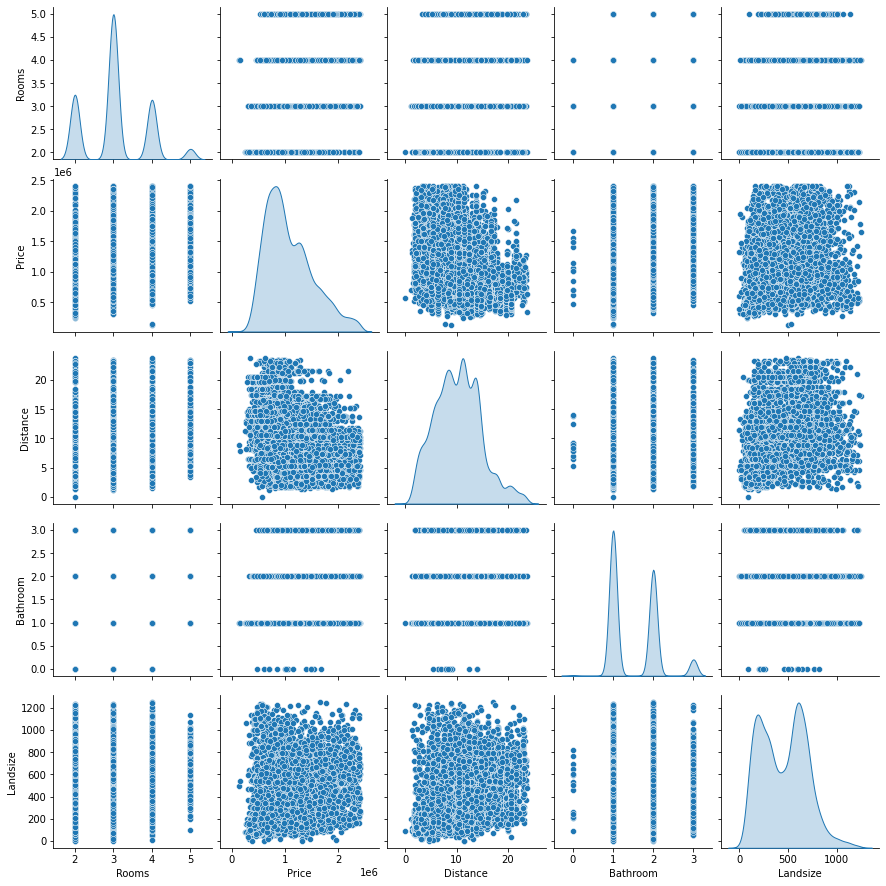

In [33]:
# Distribution of variables:
sns.pairplot(data, diag_kind = 'kde')

Coding of a non numerical variable 'Type':

In [34]:
data = pd.get_dummies(data, columns = ['Type'], prefix_sep = ': ')
data

,Rooms,Price,Distance,Bathroom,Landsize,Type: h,Type: t,Type: u
0,2,1480000.0,2.5,1.0,202.0,1,0,0
1,2,1035000.0,2.5,1.0,156.0,1,0,0
2,3,1465000.0,2.5,2.0,134.0,1,0,0
3,3,850000.0,2.5,2.0,94.0,1,0,0
4,4,1600000.0,2.5,1.0,120.0,1,0,0
...,...,...,...,...,...,...,...,...
13573,4,635000.0,14.7,2.0,662.0,1,0,0
13574,3,582000.0,16.5,2.0,256.0,1,0,0
13575,4,1245000.0,16.7,2.0,652.0,1,0,0
13576,3,1031000.0,6.8,2.0,333.0,1,0,0


# Building a ML model with scikit-learn module

In [35]:
# Train/test split:
X = data.drop(columns = 'Price')
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size = 0.25, random_state = 2000)

# Dimensions of datasets:
print('X_train: ', X_train.shape, ', X_test: ', X_test.shape, '\n y_train: ', y_train.shape, 'y_test: ', y_test.shape)

# Standarization of X variables:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

X_train

X_train:  (7156, 7) , X_test:  (2386, 7) 
 y_train:  (7156,) y_test:  (2386,)


,Rooms,Distance,Bathroom,Landsize,Type: h,Type: t,Type: u
12953,4,22.2,2.0,364.0,1,0,0
115,2,3.3,1.0,79.0,1,0,0
588,2,9.2,1.0,253.0,1,0,0
10302,3,11.2,1.0,584.0,1,0,0
12635,3,9.4,1.0,667.0,1,0,0
...,...,...,...,...,...,...,...
5297,3,2.6,1.0,204.0,1,0,0
6298,2,6.5,1.0,333.0,1,0,0
2162,4,13.9,2.0,182.0,0,1,0
5891,3,9.7,2.0,606.0,1,0,0


In [36]:
# To predict, we will use 5 linear models:
models = {'Standard linear': linear_model.LinearRegression(),
          'Ridge': linear_model.Ridge(),
          'Lasso': linear_model.Lasso(),
          'Elastic Net': linear_model.ElasticNet(),
          'Random Forest': RandomForestRegressor()}

# Prediction on models:
for key in models:
  reg = models[key]
  reg.fit(X_train_std, y_train)

  y_pred = reg.predict(X_test_std)

  print(f'Used model: {models[key]}')
  MSE = metrics.mean_squared_error(y_test, y_pred)
  RMSE = np.sqrt(MSE)
  print(f'RMSE = {round(RMSE, 4)}')
  print('-------------------------------------------------------------------')

Used model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE = 4.548695210635399e+16
-------------------------------------------------------------------
Used model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
RMSE = 345621.215
-------------------------------------------------------------------
Used model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
RMSE = 345623.4245
-------------------------------------------------------------------
Used model: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
RMSE = 356996.6035
---------------------------

In [37]:
# Model validation:
for key in models:
  stand = StandardScaler()
  model = models[key]
  proces = pipeline.make_pipeline(stand, model)
  validation = KFold(n_splits = 10,
                     shuffle = True,
                     random_state = 2000)
  
  validation_neg_MSE = cross_val_score(proces, X_train, y_train,
                                       cv = validation,
                                       scoring = 'neg_mean_squared_error',
                                       n_jobs = -1)
  
  validation_RMSE = np.sqrt( - validation_neg_MSE)

  print(f'Used model: {model}')
  print(f'Avg RMSE for this model = {validation_RMSE.mean()}')
  print('-----------------------------------------------------------------')

Used model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Avg RMSE for this model = 352141.13614172477
-----------------------------------------------------------------
Used model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Avg RMSE for this model = 352116.0645783438
-----------------------------------------------------------------
Used model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Avg RMSE for this model = 352116.16679433733
-----------------------------------------------------------------
Used model: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, wa

In [38]:
# Optimalization of selected model:
selected_model = RandomForestRegressor()

Parameter_grid = [{'n_estimators': [25, 50, 75, 100],
                   'min_samples_split': [2, 10, 20],
                   'max_depth': [3, 5, None],
                   'bootstrap': [True, False],
                   'n_estimators': [50, 100, 500],
                   'min_samples_leaf': [1, 5, 10],
                   'max_features': ['auto', 'sqrt']}]

validation = KFold(n_splits = 10, shuffle = True, random_state = 2000)

configuration = pipeline.make_pipeline(StandardScaler(),
                                       GridSearchCV(selected_model,
                                                    Parameter_grid,
                                                    cv = validation,
                                                    verbose = 5,
                                                    scoring = 'neg_mean_squared_error',
                                                    n_jobs = -1))

configuration.fit(X_train, y_train)

configuration_grid = configuration.named_steps['gridsearchcv']

print('Optimal parameters: ')
configuration_grid.best_params_

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 33.7min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be ca

Optimal parameters: 


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

In [39]:
# Prediction on best params:
best_model = RandomForestRegressor(bootstrap = True,
                                   max_depth = None,
                                   max_features = 'auto',
                                   min_samples_leaf = 1,
                                   min_samples_split = 10,
                                   n_estimators = 500)

best_model.fit(X_train_std, y_train)

y_pred_best = best_model.predict(X_test_std)

MSE = metrics.mean_squared_error(y_test, y_pred_best)
RMSE = np.sqrt(MSE)
print(f'RMSE = {round(RMSE, 4)}')

# Save result:
scikit_learn_RMSE = RMSE

RMSE = 302626.1398


# Building a neural network with TensorFlow module

In [40]:
# Train / test split:

train_data = data.sample(frac = 0.75, random_state = 0)
test_data = data.drop(train_data.index)

X_train = train_data.drop(columns = 'Price')
y_train = train_data['Price']

X_test = test_data.drop(columns = 'Price')
y_test = test_data['Price']

print('X_train:', X_train.shape, '\n', 'y_train:', y_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_test:', y_test.shape)

X_train: (7156, 7) 
 y_train: (7156,) 
 X_test: (2386, 7) 
 y_test: (2386,)


In [41]:
# First layer of neural network: normalization of describing variables:
normalizer = preprocessing.Normalization(axis = -1)

normalizer.adapt(np.array(X_train))
normalizer.adapt(np.array(X_test))

print(normalizer.mean.numpy())

[[3.0498743e+00 1.0078292e+01 1.5058678e+00 4.5193042e+02 8.0930436e-01
  8.8851646e-02 1.0184410e-01]]


DNN Regression

In [42]:
# Build and compile the model function:
def build_and_compile_model(norm):
  model = keras.Sequential([norm,
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(1)])
  
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001))

  return model

# Using function:
# Compile:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

# Train the model:

history = dnn_model.fit(X_train, y_train, validation_split = 0.2, verbose = 0, epochs = 100)
y_pred = dnn_model.predict(X_test_std)

# RMSE:
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print(f'RMSE = {round(RMSE, 4)}')

# Save result:
TensorFlow_RMSE = RMSE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________
RMSE = 775181.4342
